# Previsione della Qualità dell'Aria - **Allenamento e Valutazione dei Modelli**

**Progetto di Data Intensive**  
**Autore:** Martin Tomassi, Jacopo Vasi  
**Email:** martin.tomassi@studio.unibo.it , jacopo.vasi@studio.unibo.it  
**Corso:** Data Intensive, Università di Bologna  
**Data:** Aprile 2025

## Caricamento dei Datasets ed Import Librerie



In [1]:
import os.path
from urllib.request import urlretrieve
import requests
import zipfile
import io
import glob
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_theme()

%pip install tqdm
from tqdm import tqdm

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_log_error,
    explained_variance_score,
    max_error
)
from sklearn.model_selection import (
    TimeSeriesSplit,
    RandomizedSearchCV,
    GridSearchCV,
    ParameterSampler
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet
)

import xgboost as xgb
from IPython.display import clear_output
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

%pip install xgboost
from xgboost import XGBRegressor

N_JOBS = -1
RANDOM_STATE = 42

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/vMxster/Data_Project/main/Datasets/original_dataset.csv',
                 sep=',',
                 quotechar='"',
                 dtype=None,
                 parse_dates=True,
                 low_memory=False)
obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype("string")
df.drop('date', axis=1, inplace=True)
df.head()

,year,month,dayofmonth,state,PM2.5,CO,O3,dayofweek,quarter,weekofyear,...,o3_lag_1Y,pm_lag_2Y,co_lag_2Y,o3_lag_2Y,pm_lag_1M,co_lag_1M,o3_lag_1M,pm_lag_1W,co_lag_1W,o3_lag_1W
0,2015,1,1,Wanshouxigong,35.208333,1137.500000,34.291667,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,Huairou,22.791667,870.833333,30.083333,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,Aotizhongxin,38.166667,941.666667,24.166667,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,Uttar Pradesh,322.298261,6.678757,33.138014,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,Dongsi,28.333333,1000.000000,33.750000,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63906 entries, 0 to 63905
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        63906 non-null  int64  
 1   month       63906 non-null  int64  
 2   dayofmonth  63906 non-null  int64  
 3   state       63906 non-null  string 
 4   PM2.5       63906 non-null  float64
 5   CO          63906 non-null  float64
 6   O3          63906 non-null  float64
 7   dayofweek   63906 non-null  int64  
 8   quarter     63906 non-null  int64  
 9   weekofyear  63906 non-null  int64  
 10  dayofyear   63906 non-null  int64  
 11  pm_lag_1Y   48593 non-null  float64
 12  co_lag_1Y   48593 non-null  float64
 13  o3_lag_1Y   48593 non-null  float64
 14  pm_lag_2Y   34756 non-null  float64
 15  co_lag_2Y   34756 non-null  float64
 16  o3_lag_2Y   34756 non-null  float64
 17  pm_lag_1M   62616 non-null  float64
 18  co_lag_1M   62616 non-null  float64
 19  o3_lag_1M   62616 non-nul

In [4]:
df_daily = pd.read_csv('https://raw.githubusercontent.com/vMxster/Data_Project/main/Datasets/augmented_dataset.csv',
                       sep=',',
                       quotechar='"',
                       dtype=None,
                       parse_dates=True,
                       low_memory=False)
obj_cols = df_daily.select_dtypes(include="object").columns
for col in obj_cols:
    df_daily[col] = df_daily[col].astype("string")
df_daily.drop('date', axis=1, inplace=True)
df_daily.head()

,year,month,dayofmonth,state,PM2.5,CO,O3,dayofweek,quarter,weekofyear,...,o3_lag_1Y,pm_lag_2Y,co_lag_2Y,o3_lag_2Y,pm_lag_1M,co_lag_1M,o3_lag_1M,pm_lag_1W,co_lag_1W,o3_lag_1W
0,2015,1,1,Bihar,92.000000,0.740000,43.160000,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,Gujarat,27.211081,5.068095,104.372381,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,Maharashtra,79.599167,0.530417,0.040000,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,Uttar Pradesh,322.298261,6.678757,33.138014,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,Tamil Nadu,0.140000,1.182778,11.367708,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51912 entries, 0 to 51911
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        51912 non-null  int64  
 1   month       51912 non-null  int64  
 2   dayofmonth  51912 non-null  int64  
 3   state       51912 non-null  string 
 4   PM2.5       51912 non-null  float64
 5   CO          51912 non-null  float64
 6   O3          51912 non-null  float64
 7   dayofweek   51912 non-null  int64  
 8   quarter     51912 non-null  int64  
 9   weekofyear  51912 non-null  int64  
 10  dayofyear   51912 non-null  int64  
 11  pm_lag_1Y   40979 non-null  float64
 12  co_lag_1Y   40979 non-null  float64
 13  o3_lag_1Y   40979 non-null  float64
 14  pm_lag_2Y   33005 non-null  float64
 15  co_lag_2Y   33005 non-null  float64
 16  o3_lag_2Y   33005 non-null  float64
 17  pm_lag_1M   50982 non-null  float64
 18  co_lag_1M   50982 non-null  float64
 19  o3_lag_1M   50982 non-nul

# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei due dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `year`: anno della misurazione
- `month`: mese dell’anno
- `dayofmonth`: giorno del mese
- `dayofweek`: giorno della settimana
- `dayofyear`: giorno dell’anno
- `weekofyear`: settimana dell’anno
- `quarter`: trimestre dell’anno
- `state`: stato di misurazione
- `pm_lag_1W`: PM2.5 ritardato di 1 settimana
- `pm_lag_1M`: PM2.5 ritardato di 1 mese
- `pm_lag_1Y`: PM2.5 ritardato di 1 anno
- `pm_lag_2Y`: PM2.5 ritardato di 2 anni
- `co_lag_1W`: CO ritardato di 1 settimana
- `co_lag_1M`: CO ritardato di 1 mese
- `co_lag_1Y`: CO ritardato di 1 anno
- `co_lag_2Y`: CO ritardato di 2 anni
- `o3_lag_1W`: O3 ritardato di 1 settimana
- `o3_lag_1M`: O3 ritardato di 1 mese
- `o3_lag_1Y`: O3 ritardato di 1 anno
- `o3_lag_2Y`: O3 ritardato di 2 anni

La variabile dipendente target dell'addestramento è `PM2.5`, che indica la concentrazione di particelle inquinanti nell'aria con un diametro inferiore a 2,5 micron (μm).

## Preparazione Dataset
Per garantire un confronto equo tra tutti i modelli, alcuni dei quali non supportano i valori mancanti generati dalle lag features, elimineremo tutte le righe che li contengono. Va però tenuto presente che così facendo perdiamo un anno di dati storici. Modelli come XGBoost di scikit-learn sono in grado di gestire internamente i missing value e potrebbero beneficiarne; tuttavia, per mantenere omogenee le condizioni di allenamento, applichiamo il drop completo dei NaN.

In [6]:
target = 'PM2.5'
lag_features = ['pm_lag_1Y', 'pm_lag_2Y', 'pm_lag_1M', 'pm_lag_1W','co_lag_1Y', 'co_lag_2Y', 'co_lag_1M', 'co_lag_1W','o3_lag_1Y', 'o3_lag_2Y', 'o3_lag_1M', 'o3_lag_1W']
date_features = ['dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
predictors = date_features + lag_features

In [7]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    dataframe = dataframe.copy()

    if replace_na and method == 'zeros':
      dataframe = dataframe.fillna(0)
    elif replace_na and method == 'drop':
      dataframe = dataframe.dropna(how='any')

    train_set, test_set = np.split(dataframe, [int(len(dataframe) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [8]:
X_train, X_test, y_train, y_test = create_train_test_sets(
    df,
    split=0.8,
    replace_na=True,
    method='drop'
)

# Resetta gli indici dei risultati di create_train_test_sets eliminando l’indice precedente,
# in modo da partire da zero e avere indici continui
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27804 entries, 0 to 27803
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dayofmonth  27804 non-null  int64  
 1   dayofweek   27804 non-null  int64  
 2   dayofyear   27804 non-null  int64  
 3   weekofyear  27804 non-null  int64  
 4   month       27804 non-null  int64  
 5   quarter     27804 non-null  int64  
 6   year        27804 non-null  int64  
 7   pm_lag_1Y   27804 non-null  float64
 8   pm_lag_2Y   27804 non-null  float64
 9   pm_lag_1M   27804 non-null  float64
 10  pm_lag_1W   27804 non-null  float64
 11  co_lag_1Y   27804 non-null  float64
 12  co_lag_2Y   27804 non-null  float64
 13  co_lag_1M   27804 non-null  float64
 14  co_lag_1W   27804 non-null  float64
 15  o3_lag_1Y   27804 non-null  float64
 16  o3_lag_2Y   27804 non-null  float64
 17  o3_lag_1M   27804 non-null  float64
 18  o3_lag_1W   27804 non-null  float64
dtypes: float64(12), int64(7)


In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6952 entries, 0 to 6951
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dayofmonth  6952 non-null   int64  
 1   dayofweek   6952 non-null   int64  
 2   dayofyear   6952 non-null   int64  
 3   weekofyear  6952 non-null   int64  
 4   month       6952 non-null   int64  
 5   quarter     6952 non-null   int64  
 6   year        6952 non-null   int64  
 7   pm_lag_1Y   6952 non-null   float64
 8   pm_lag_2Y   6952 non-null   float64
 9   pm_lag_1M   6952 non-null   float64
 10  pm_lag_1W   6952 non-null   float64
 11  co_lag_1Y   6952 non-null   float64
 12  co_lag_2Y   6952 non-null   float64
 13  co_lag_1M   6952 non-null   float64
 14  co_lag_1W   6952 non-null   float64
 15  o3_lag_1Y   6952 non-null   float64
 16  o3_lag_2Y   6952 non-null   float64
 17  o3_lag_1M   6952 non-null   float64
 18  o3_lag_1W   6952 non-null   float64
dtypes: float64(12), int64(7)
me

Nel dataset ci sono sia feature numeriche che categoriche. <br>
Per le numeriche è necessario applicare una normalizzazione dei dati, i quali avrebbero altrimenti valori su scale molto diverse che renderebbero più difficile la convergenza del modello. <br>
Per poter utilizzare le variabili categoriche nell'addestramento di un modello di regressione si usa un OneHotEncoder, creando nuove colonne binarie per ciascuno dei valori ammissibili dalla variabile categorica.

In [11]:
categorical_features = X.select_dtypes(include=["string"]).columns.tolist()
numerical_features   = [c for c in X.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    # Standardizza tutte le colonne numeriche
    ("numeric",    StandardScaler(),    numerical_features),
    # One‑hot encoding di 'state', ignorando nuovi stati in predict
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

Inizializzazione della lista per raccogliere le metriche dopo ogni training

In [12]:
all_scores = []

## Valutazione delle Prestazioni dei Modelli Allenati

Dopo l'allenamento di ciascun modello di Machine Learning e Deep Learning, utilizziamo la funzione `get_estimator_scores` e `get_torch_estimator_scores` per calcolare diverse metriche di valutazione, includendo per le principali anche gli **Intervalli di Confidenza al 95%** (CI95%) stimati tramite bootstrap resampling.

Le metriche calcolate sono:

1. **$R^2$ (Coefficiente di Determinazione)**  
   Misura quanto bene un modello riesce a spiegare la variabilità della variabile dipendente. Il valore di $R^2$ varia da 0 (nessuna capacità predittiva) a 1 (predizione perfetta).  
   Un $R^2_{\text{test}}$ significativamente inferiore rispetto a $R^2_{\text{train}}$ indica possibile overfitting.  
   *(Più alto è, meglio è.)*

2. **Root Mean Squared Error (RMSE)**  
   Misura la deviazione standard degli errori di previsione (la radice quadrata del MSE). Penalizza maggiormente gli errori più grandi.  
   *(Più basso è, meglio è.)*

3. **Mean Absolute Error (MAE)**  
   Rappresenta la media delle differenze assolute tra i valori reali e quelli predetti. È meno sensibile agli outlier rispetto all’RMSE.  
   *(Più basso è, meglio è.)*

4. **Mean Absolute Percentage Error (MAPE)**  
   Misura la precisione percentuale di un sistema di previsione. Indica, in media, quanto si discosta una previsione rispetto al valore reale.  
   *(Più basso è, meglio è.)*

5. **Mean Squared Logarithmic Error (MSLE)**  
   Utile quando si vuole penalizzare maggiormente gli errori relativi per valori piccoli e avere tolleranza su valori grandi.  
   *(Più basso è, meglio è.)*

6. **Explained Variance Score**  
   Misura la proporzione della varianza spiegata dal modello, simile a $R^2$, ma può essere più informativo in caso di regressione non lineare.  
   *(Più alto è, meglio è.)*

7. **Max Error**  
   Misura l’errore assoluto massimo commesso in una previsione.  
   *(Più basso è, meglio è.)*


In [13]:
def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    for _ in range(n_bootstraps):
        if running_in_colab:
            idx = np.random.randint(0, len(y_true), len(y_true))
            vals.append(metric_fn(y_true[idx], y_pred[idx]))
        else:
            idx = np.random.randint(0, len(y_true), len(y_true))
            vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx]))

    low = np.percentile(vals, 100 * (alpha/2))
    high = np.percentile(vals, 100 * (1 - alpha/2))
    return low, high

def get_estimator_scores(model_name, model):
    y_pred = model.predict(X_test)
    r2_tr = model.score(X_train, y_train)
    r2_te = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    msle = mean_squared_log_error(y_test, np.maximum(y_pred, 0))
    evs = explained_variance_score(y_test, y_pred)
    me = max_error(y_test, y_pred)

    rmse_low, rmse_high = bootstrap_ci(lambda a,b: np.sqrt(mean_squared_error(a, b)), y_test, y_pred)
    mae_low, mae_high = bootstrap_ci(mean_absolute_error, y_test, y_pred)
    mape_low, mape_high = bootstrap_ci(mean_absolute_percentage_error, y_test, y_pred)

    all_scores.append([
        model_name, r2_tr, r2_te,
        rmse, rmse_low, rmse_high,
        mae, mae_low, mae_high,
        mape, mape_low, mape_high,
        msle, evs, me
    ])

def predict_torch(model, X_tensor, device):
    model.eval()
    with torch.no_grad():
        out = model(X_tensor.to(device))
    out_cpu = out.detach().cpu().numpy()
    # Se il modello restituisce shape (N,1), appiattiamo a (N,)
    if out_cpu.ndim == 2 and out_cpu.shape[1] == 1:
        return out_cpu.ravel()
    return out_cpu

def get_torch_estimator_scores(model_name, model,
                               X_train, y_train,
                               X_test, y_test,
                               device):
    y_pred_train = predict_torch(model, X_train, device)
    y_pred_test  = predict_torch(model, X_test,  device)

    y_train_np = y_train.detach().cpu().numpy().ravel()
    y_test_np  = y_test.detach().cpu().numpy().ravel()

    r2_tr = r2_score(y_train_np, y_pred_train)
    r2_te = r2_score(y_test_np,  y_pred_test)

    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_test))
    rmse_low, rmse_high = bootstrap_ci(
        lambda a, b: np.sqrt(mean_squared_error(a, b)),
        y_test_np, y_pred_test
    )

    mae = mean_absolute_error(y_test_np, y_pred_test)
    mae_low, mae_high = bootstrap_ci(mean_absolute_error, y_test_np, y_pred_test)
    mape = mean_absolute_percentage_error(y_test_np, y_pred_test)
    mape_low, mape_high = bootstrap_ci(mean_absolute_percentage_error,
                                       y_test_np, y_pred_test)
    msle = mean_squared_log_error(y_test_np, np.maximum(y_pred_test, 0))
    evs = explained_variance_score(y_test_np, y_pred_test)
    me = max_error(y_test_np, y_pred_test)

    all_scores.append([
        model_name, r2_tr, r2_te,
        rmse, rmse_low, rmse_high,
        mae, mae_low, mae_high,
        mape, mape_low, mape_high,
        msle, evs, me
    ])

## Regressione lineare
Il modello più semplice da addestrare è la regressione lineare, senza filtri polinomiali o regolarizzazioni. Grazie all'elevato numero di dati usato per l'addestramento, si possono ottenere degli ottimi risultati, anche se migliorabili, già con questo primo modello.

In [14]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , LinearRegression())
])

In [15]:
%time model.fit(X_train, y_train)
get_estimator_scores("lin_reg", model)

CPU times: user 27.9 ms, sys: 2.78 ms, total: 30.7 ms
Wall time: 44 ms


## Regressione polinomiale
Per provare ad ottenere risultati migliori, vengono introdotte le feature polinomiali, che aggiungono nuove feature di grado superiore. Si esclude il bias, che consiste nel valore dell'intercetta, e si escludono i prodotti tra le diverse feature, per esempio i doppi prodotti in una regressione polinomiale di grado 2.

In [16]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr"   , LinearRegression())
])

In [17]:
%time model.fit(X_train, y_train)
get_estimator_scores("poly_reg", model)

CPU times: user 1.15 s, sys: 42 ms, total: 1.19 s
Wall time: 1.14 s


## Regressione LASSO
La regressione LASSO è un'ottima tecnica per selezionare le feature più importanti, poichè la discesa del gradiente si ferma su un vertice di un ipercubo centrato sull'origine, quindi azzera i parametri delle variabili meno rilevanti.

In [67]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr", Lasso(alpha=1, max_iter=10000))
])

In [68]:
%time model.fit(X_train, y_train)

CPU times: user 68.3 ms, sys: 900 µs, total: 69.2 ms
Wall time: 74.9 ms


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['dayofmonth', 'dayofweek',
                                                   'dayofyear', 'weekofyear',
                                                   'month', 'quarter', 'year',
                                                   'pm_lag_1Y', 'pm_lag_2Y',
                                                   'pm_lag_1M', 'pm_lag_1W',
                                                   'co_lag_1Y', 'co_lag_2Y',
                                                   'co_lag_1M', 'co_lag_1W',
                                                   'o3_lag_1Y', 'o3_lag_2Y',
                                                   'o3_lag_1M', 'o3_lag_1W']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('regr', Lasso(alpha=1, max_iter=10000))])

### Grid Search per l'iperparametro della Lasso
Per ricercare gli iperparametri migliori nei prossimi modelli da addestrare, verrà usata la grid search o random search, che addestra il modello con tutte le combinazioni possibili di iperparametri selezionati. <br>
All'interno della grid search, suddividiamo i dati in 5 sottoinsiemi disgiunti, i fold della cross validation, per garantire che il modello riesca a generalizzare su dati non visti. <br>
Con la grid search si ottiene lo score del modello al variare dell'iperparametro della regolarizzazione LASSO per vedere quanta regolarizzazione è necessaria ai fini dell'addestramento.

In [21]:
tscv = TimeSeriesSplit(n_splits=5)

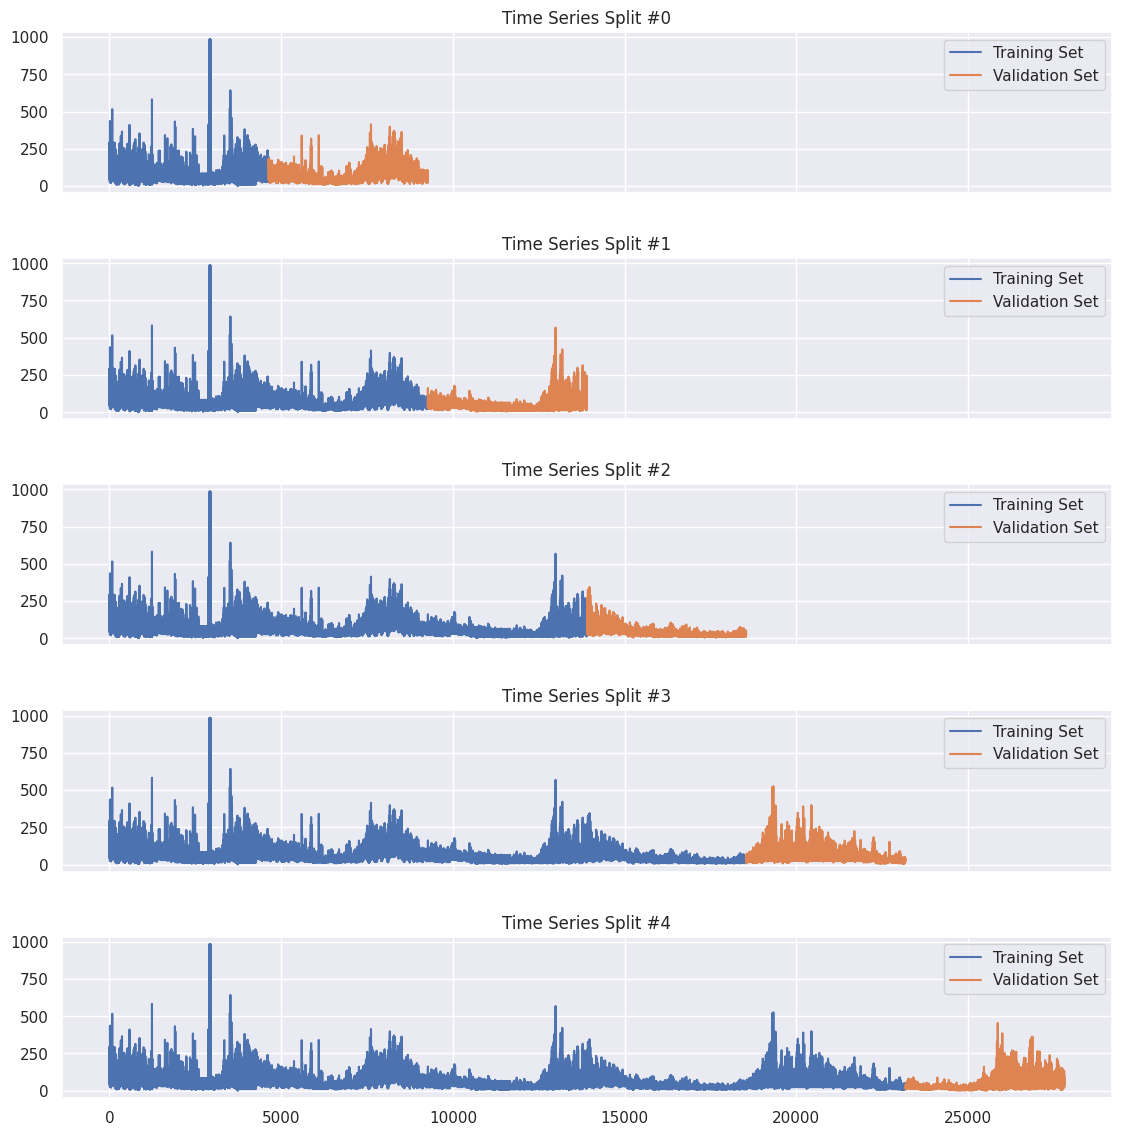

In [22]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)):
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

plt.show()

In [71]:
alphas = np.logspace(-3, 1, num=5)
grid = {"regr__alpha": alphas}
gs = RandomizedSearchCV(model, grid, n_iter=5, cv=tscv, n_jobs=N_JOBS)

In [72]:
%time gs.fit(X_train, y_train);
print()

CPU times: user 209 ms, sys: 23.6 ms, total: 233 ms
Wall time: 13.4 s



In [73]:
get_estimator_scores("lasso_reg", gs.best_estimator_)

In [74]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha", "mean_test_score"]]

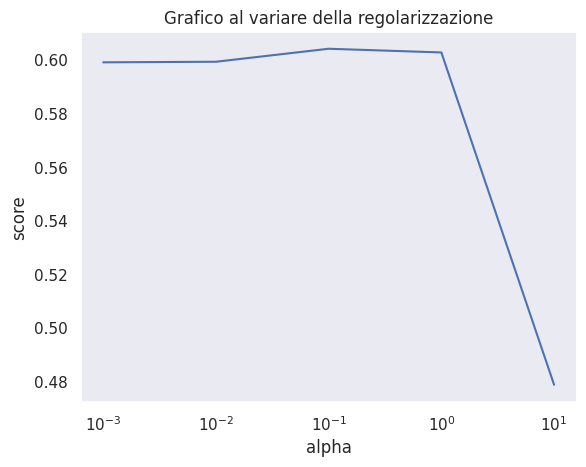

In [75]:
plt.grid()
plt.plot(results["param_regr__alpha"], results["mean_test_score"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Grafico al variare della regolarizzazione')
plt.show()

## Regressione Ridge
Proviamo la regolarizzazione con feature polinomiali per ridurre un eventuale overfitting.

In [76]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", Ridge(alpha=1, max_iter=10000))
])

In [77]:
%time model.fit(X_train, y_train)

CPU times: user 286 ms, sys: 15.4 ms, total: 301 ms
Wall time: 212 ms


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['dayofmonth', 'dayofweek',
                                                   'dayofyear', 'weekofyear',
                                                   'month', 'quarter', 'year',
                                                   'pm_lag_1Y', 'pm_lag_2Y',
                                                   'pm_lag_1M', 'pm_lag_1W',
                                                   'co_lag_1Y', 'co_lag_2Y',
                                                   'co_lag_1M', 'co_lag_1W',
                                                   'o3_lag_1Y', 'o3_lag_2Y',
                                                   'o3_lag_1M', 'o3_lag_1W']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('regr', Ridge(alpha=1, max_iter=10000))])

### Grid Search per l'iperparametro della Ridge

In [78]:
alphas = np.logspace(-2, 8, num=12)
grid = {"regr__alpha": alphas}
gs = RandomizedSearchCV(model, grid, n_iter=12, cv=tscv, n_jobs=N_JOBS)

In [79]:
%time gs.fit(X_train, y_train)
print()

CPU times: user 624 ms, sys: 34.3 ms, total: 658 ms
Wall time: 4.95 s



In [80]:
get_estimator_scores("ridge_reg", gs.best_estimator_)

In [81]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha", "mean_test_score"]]

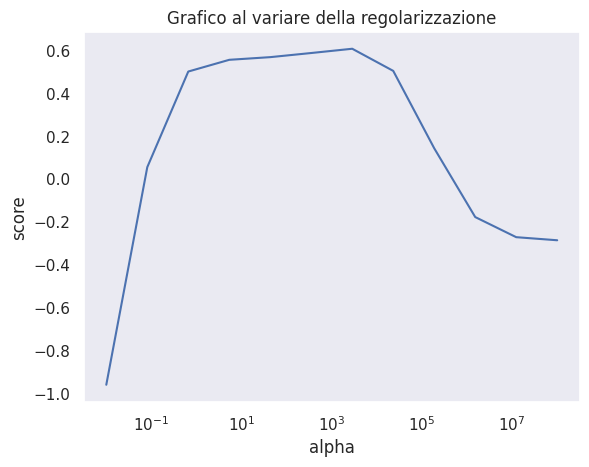

In [82]:
plt.grid()
plt.plot(results["param_regr__alpha"], results["mean_test_score"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Grafico al variare della regolarizzazione')
plt.show()

## Regressione Elastic Net
Questa regressione unisce la regolarizzazione LASSO e la regolarizzazione Ridge.

In [83]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", ElasticNet(alpha=0.2, l1_ratio=0.1))
])

In [84]:
%time model.fit(X_train, y_train)

CPU times: user 6.6 s, sys: 37.1 ms, total: 6.64 s
Wall time: 3.46 s


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['dayofmonth', 'dayofweek',
                                                   'dayofyear', 'weekofyear',
                                                   'month', 'quarter', 'year',
                                                   'pm_lag_1Y', 'pm_lag_2Y',
                                                   'pm_lag_1M', 'pm_lag_1W',
                                                   'co_lag_1Y', 'co_lag_2Y',
                                                   'co_lag_1M', 'co_lag_1W',
                                                   'o3_lag_1Y', 'o3_lag_2Y',
                                                   'o3_lag_1M', 'o3_lag_1W']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('regr', ElasticNet(alpha=0.2, l1_ratio=0.1))])

### Grid Search per Elastic Net
Nella grid search cerchiamo i valori migliori di `alpha`, iperparametro della regolarizzazione, e di `l1_ratio`, iperparametro per gestire l'unione di LASSO e Ridge.

In [85]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__l1_ratio": [0.1, 0.2, 0.3]
}
gs = RandomizedSearchCV(model, grid, n_iter=9, cv=tscv, n_jobs=N_JOBS)

In [86]:
%time gs.fit(X_train, y_train);
print()

CPU times: user 11.4 s, sys: 128 ms, total: 11.5 s
Wall time: 54.8 s



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.570e+04, tolerance: 7.748e+03
  model = cd_fast.enet_coordinate_descent(


In [87]:
get_estimator_scores("elastic_net_reg", gs.best_estimator_)

## Regressione con funzioni kernel
Per ovviare ai problemi di prestazioni dei modelli con feature polinomiali, usiamo il kernel trick per evitare di creare un numero elevato di feature aggiuntive.

## Funzioni kernel polinomiali

In [39]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr",  KernelRidge(alpha=1, kernel="poly", degree=10))
])

In [ ]:
%time model.fit(X_train, y_train)
print()

### Grid Search per funzioni kernel polinomiali
Questa grid search cerca i valori ottimali del peso della regolarizzazione e del grado della funzione kernel polinomiale.

In [ ]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__degree": list(range(2,30))
}
gs = RandomizedSearchCV(model, grid, n_iter=20, cv=tscv, n_jobs=N_JOBS)

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = |\text{max_depth}| \times |\text{min_samples_split}| = 28 \times 4 = 84 $$

Supponiamo di voler avere una probabilità \(P = 0.90\) di includere almeno una delle migliori \(k = 10\) configurazioni tra queste 84.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo l’approssimazione:

$$
n \approx - \frac{\ln(1 - 0.90)}{10/104} = \frac{2.3026}{10/84} = 2.3026 \times \frac{84}{10} \approx 20
$$

Quindi, con **20 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando rispetto a un Grid Search completo con 84 tentativi.




**Da dove viene la formula per stimare il numero di iterazioni nel Randomized Search?**

Per stimare quante iterazioni (`n`) sono necessarie per avere una certa probabilità \(P\) di includere almeno una configurazione tra le \(k\) migliori (su \(M\) totali), usiamo la seguente logica probabilistica:

1. Probabilità di *non* pescare una top-\(k\) in un singolo tentativo.
Se ci sono \(M\) configurazioni totali e \(k\) di esse sono “quasi ottimali”, la probabilità di *non* sceglierne una buona è:
$$
1 - \frac{k}{M}
$$

2. Probabilità di non pescarne *nessuna* in \(n\) tentativi indipendenti
$$
\left(1 - \frac{k}{M} \right)^n
$$

3. Probabilità di pescare **almeno una** delle top-\(k\)
$$
P(\text{≥1 top-}k) = 1 - \left(1 - \frac{k}{M} \right)^n
$$

4. Ricavare \(n\) dalla formula
$$
1 - \left(1 - \frac{k}{M} \right)^n = P
\quad \Longrightarrow \quad
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M} \right)}
$$

5. Approssimazione per $$ k \ll M $$
Poiché $$ \ln(1 - x) \approx -x $$ per \(x\) piccolo:
$$
n \approx - \frac{\ln(1 - P)}{k/M}
$$

In [ ]:
%time gs.fit(X_train, y_train)
print()

In [ ]:
get_estimator_scores("kernel_poly_reg", gs.best_estimator_)

In [ ]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha","param_regr__degree","mean_test_score"]]
results_0_1 = results[results["param_regr__alpha"] == 0.1]
results_1 = results[results["param_regr__alpha"] == 1]
results_10 = results[results["param_regr__alpha"] == 10]

In [ ]:
plt.grid()
plt.plot(results_0_1["param_regr__degree"], results_0_1["mean_test_score"])
plt.plot(results_1["param_regr__degree"], results_1["mean_test_score"], c="red")
plt.plot(results_10["param_regr__degree"], results_10["mean_test_score"], c="green")
plt.xlabel('degree')
plt.ylabel('score')
plt.legend(["alpha=0.1","alpha=1","alpha=10"])
plt.title('Grafico al variare del grado della funzione kernel polinomiale')
plt.show()

## Funzioni kernel gaussiane

Testiamo anche funzioni kernel diverse, ad esempio RBF (_radial basis function_). <br>
La funzione RBF ha la forma di una gaussiana.

In [47]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr",  KernelRidge(alpha=1, kernel="rbf", gamma=0.01))
])

In [ ]:
%time model.fit(X_train, y_train)
print()

### Grid Search per funzioni kernel gaussiane

In [ ]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__gamma": [0.01, 0.1, 1]
}
gs = RandomizedSearchCV(model, grid, n_iter=9, cv=tscv, n_jobs=N_JOBS)

In [ ]:
%time gs.fit(X_train, y_train)
print()

In [ ]:
get_estimator_scores("kernel_rbf_reg", gs.best_estimator_)

## Alberi decisionali

In [23]:
model = Pipeline([
    ("preproc", preprocessor),
    ("tree", DecisionTreeRegressor(max_depth=4, random_state=42))
])

In [24]:
%time model.fit(X_train, y_train)
print()

CPU times: user 213 ms, sys: 2.17 ms, total: 215 ms
Wall time: 215 ms



### Grid Search per alberi decisionali
Cerchiamo i valori ottimali della profondità massima dell'albero decisionale e del numero minimo di campioni all'interno di ciascun nodo per poter essere suddiviso a sua volta.

In [25]:
grid = {
    "tree__max_depth": list(range(4,30)),
    "tree__min_samples_split": [0.005, 0.01, 0.1, 0.15],
}
gs = RandomizedSearchCV(model, grid, n_iter=24, cv=tscv, n_jobs=N_JOBS)

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali: $$ M = |\text{max_depth}| \times |\text{min_samples_split}| = 26 \times 4 = 104 $$

Supponiamo di voler avere una probabilità \(P = 0.90\) di includere almeno una delle migliori \(k = 10\) configurazioni tra queste 104.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo l’approssimazione:

$$
n \approx - \frac{\ln(1 - 0.90)}{10/104} = \frac{2.3026}{10/104} = 2.3026 \times \frac{104}{10} \approx 24
$$

Quindi, con **24 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando rispetto a un Grid Search completo con 104 tentativi.



In [26]:
%time gs.fit(X_train, y_train)
print()

CPU times: user 824 ms, sys: 51.3 ms, total: 875 ms
Wall time: 22.3 s



In [27]:
get_estimator_scores("decision_tree_reg", gs.best_estimator_)

In [33]:
results = pd.DataFrame(gs.cv_results_)[[
    "param_tree__min_samples_split",
    "param_tree__max_depth",
    "mean_test_score"
]]
splits = sorted(results["param_tree__min_samples_split"].unique())

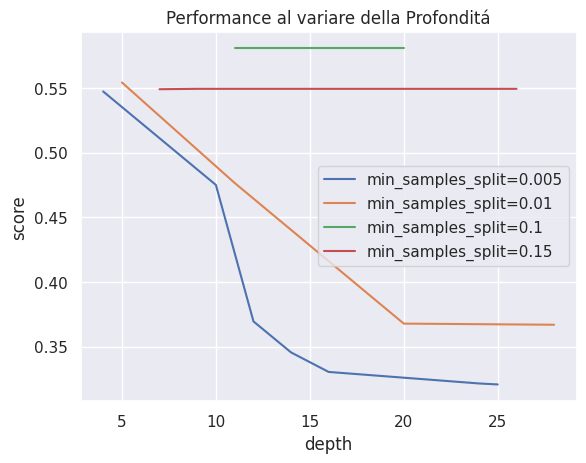

In [35]:
for split in splits:
    subset = results[results["param_tree__min_samples_split"] == split]
    subset = subset.sort_values("param_tree__max_depth")
    plt.plot(
        subset["param_tree__max_depth"],
        subset["mean_test_score"],
        label=f"min_samples_split={split}"
    )

plt.xlabel('depth')
plt.ylabel('score')
plt.title("Performance al variare della Profonditá")
plt.legend()
plt.show()

## Random forest

In [88]:
model = Pipeline([
    ("preproc", preprocessor),
    ("tree", RandomForestRegressor(max_samples=0.2, max_features="sqrt", n_estimators=200, max_depth=None, n_jobs=-1))
])

In [89]:
%time model.fit(X_train, y_train)
print()

CPU times: user 9.23 s, sys: 109 ms, total: 9.34 s
Wall time: 4.84 s



Possiamo ricavare le 10 feature più importanti per la Random Forest, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [90]:
pd.Series(model.named_steps["tree"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

,0
numeric__pm_lag_1W,0.209432
numeric__pm_lag_1Y,0.147790
numeric__pm_lag_2Y,0.111552
numeric__pm_lag_1M,0.107755
numeric__co_lag_1Y,0.049310
numeric__co_lag_1W,0.047442
numeric__dayofyear,0.045148
numeric__co_lag_2Y,0.039062
numeric__co_lag_1M,0.037397
numeric__weekofyear,0.032141


### Grid Search per random forest
Nella grid search cerchiamo i valori ottimali di `max_samples`, il numero massimo di campioni usati nell'addestramento di ciascun albero, e di `n_estimators`, il numero di alberi decisionali della foresta.

In [91]:
grid = {
    "tree__n_estimators": [150, 200, 250, 300],
    "tree__max_samples": [0.5, 0.6, 0.8, 1.0],
}
gs = RandomizedSearchCV(model, grid, n_iter=16, cv=tscv, n_jobs=N_JOBS)

In [92]:
%time gs.fit(X_train, y_train)
print()

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [93]:
get_estimator_scores("random_forest_reg", gs.best_estimator_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
results = pd.DataFrame(gs.cv_results_)[["param_tree__n_estimators","param_tree__max_samples","mean_test_score"]]
results_0_5 = results[results["param_tree__max_samples"] == 0.5]
results_0_6 = results[results["param_tree__max_samples"] == 0.6]
results_0_8 = results[results["param_tree__max_samples"] == 0.8]
results_1 = results[results["param_tree__max_samples"] == 1.0]

In [ ]:
plt.grid()
plt.plot(results_0_5["param_tree__n_estimators"], results_0_5["mean_test_score"])
plt.plot(results_0_6["param_tree__n_estimators"], results_0_6["mean_test_score"], c="red")
plt.plot(results_0_8["param_tree__n_estimators"], results_0_8["mean_test_score"], c="green")
plt.plot(results_1["param_tree__n_estimators"], results_1["mean_test_score"], c="gold")
plt.xlabel('n trees')
plt.ylabel('score')
plt.legend(["max_samples=0.5","max_samples=0.6","max_samples=0.8","max_samples=1"])
plt.title('Grafico al variare del numero di alberi del random forest')
plt.show()

## XGBoost
XGBoost crea una foresta di alberi in cui ogni albero utilizza gli errori commessi dall'albero precedente.

In [ ]:
model = Pipeline([
    ("preproc", preprocessor),
    ("xgb", XGBRegressor(objective='reg:squarederror', n_estimators=200))
])

In [ ]:
%time model.fit(X_train, y_train)
print()

Possiamo ricavare le 5 feature più importanti per XGBoost, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [ ]:
pd.Series(model.named_steps["xgb"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(5)

### Grid Search per XGBoost
Cerchiamo i valori ottimali di due iperparametri: la profondità massima degli alberi e il numero di alberi della foresta.

In [ ]:
grid = {
    "xgb__max_depth": [3, 5, 7, 10],
    "xgb__n_estimators": [100, 200, 400, 700, 1000],
}
gs = RandomizedSearchCV(model, grid, n_iter=20, cv=tscv, n_jobs=N_JOBS)

In [ ]:
%time gs.fit(X_train, y_train)
print()

In [ ]:
get_estimator_scores("xgboost_reg", gs.best_estimator_)

In [ ]:
results = pd.DataFrame(gs.cv_results_)[["param_xgb__max_depth","param_xgb__n_estimators","mean_test_score"]]
results_3 = results[results["param_xgb__max_depth"] == 3]
results_5 = results[results["param_xgb__max_depth"] == 5]
results_7 = results[results["param_xgb__max_depth"] == 7]
results_10 = results[results["param_xgb__max_depth"] == 10]

In [ ]:
plt.grid()
plt.plot(results_3["param_xgb__n_estimators"], results_3["mean_test_score"])
plt.plot(results_5["param_xgb__n_estimators"], results_5["mean_test_score"], c="red")
plt.plot(results_7["param_xgb__n_estimators"], results_7["mean_test_score"], c="green")
plt.plot(results_10["param_xgb__n_estimators"], results_10["mean_test_score"], c="gold")
plt.xlabel('n trees')
plt.ylabel('score')
plt.legend(["max_depth=3","max_depth=5","max_depth=7","max_depth=10"])
plt.title('Grafico al variare del numero del numero di alberi di XGBoost')
plt.show()

## MLP

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout):
        super().__init__()
        layers = []
        dim = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

### Random Search con Early Stopping

Questo blocco di codice implementa una procedura completa di **Random Search** per la selezione di iperparametri di modelli di regressione in PyTorch, integrando una strategia di **Early Stopping** per migliorare l'efficienza del training.

* La classe `EarlyStopper` consente di interrompere l'addestramento anticipatamente se la loss di validazione non migliora per un numero di epoche definito (`patience`), riducendo il rischio di overfitting e velocizzando l'ottimizzazione.
* Le funzioni `train_epoch` ed `eval_loss` gestiscono rispettivamente il training e la valutazione della loss media su un dataset.
* La funzione principale `random_search` esegue una **Cross-Validation**, dove:
  * Il ciclo valuta le prestazioni generali del modello su diversi split train/test.

In [ ]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            total_loss += criterion(model(Xb), yb).item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def random_search(model_builder, param_dist, dataset,
                  n_iter=10, cv_folds=5,
                  early_patience=5,
                  early_min_delta=1e-4):
    train_keys = ['lr', 'batch_size', 'max_epochs']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    tscv = TimeSeriesSplit(n_splits=cv_folds)

    print("Avvio Random Search con Time Series Cross Validation...")
    param_iter = tqdm(ParameterSampler(param_dist, n_iter=n_iter, random_state=RANDOM_STATE), desc="Param Sets")

    for param_id, params in enumerate(param_iter):
        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}
        val_losses = []

        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
            sub_train = Subset(dataset, train_idx)
            val_set = Subset(dataset, val_idx)
            train_loader = DataLoader(sub_train, batch_size=train_params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_set, batch_size=train_params['batch_size'], shuffle=False)

            model = model_builder(**model_params).to(device)
            optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
            stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

            epoch_bar = tqdm(range(train_params['max_epochs']),
                             desc=f"Fold {fold_idx+1}/{cv_folds} | Param {param_id+1}/{n_iter}",
                             leave=False)
            for epoch in epoch_bar:
                train_epoch(model, train_loader, optimizer, nn.MSELoss())
                val_loss = eval_loss(model, val_loader, nn.MSELoss())
                epoch_bar.set_postfix(val_loss=val_loss)
                if stopper.early_stop(val_loss):
                    break

            val_losses.append(eval_loss(model, val_loader, nn.MSELoss()))

        mean_val = np.mean(val_losses)
        param_iter.set_postfix(best_val_loss=mean_val)

        if mean_val < best_val_loss:
            best_val_loss = mean_val
            best_model_params = model_params
            best_train_params = train_params
            best_model = model

    return best_model, best_model_params, best_train_params

### Esecuzione del Random Search su MLP

In questa sezione viene eseguita la **ricerca di iperparametri tramite Random Search** per **MLP (Multi-Layer Perceptron)**.

#### Definizione degli spazi degli iperparametri:

* `mlp_param_dist`: contiene combinazioni di dimensioni dei layer nascosti, tassi di dropout, learning rate, batch size e numero massimo di epoche per il training del modello MLP.


In [ ]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

# (Training + Validation) Dataset
full_dataset = TensorDataset(X_tensor, y_tensor)

input_dim = X_tensor.shape[1]
mlp_param_dist = {
    'input_dim': [input_dim],
    'hidden_sizes': [(32,32), (64,64), (128,)],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'max_epochs': [50]
}
best_model, model_params, train_params = random_search(
    lambda **p: MLP(**p), mlp_param_dist, full_dataset
)

X_train_tensor = torch.stack([full_dataset[i][0] for i in range(len(full_dataset))])
y_train_tensor = torch.stack([full_dataset[i][1] for i in range(len(full_dataset))])
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

get_torch_estimator_scores("MLP", best_model,
                           X_train_tensor.to(device), y_train_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device)

## Confronto Visivo delle Prestazioni dei Modelli

La funzione `plot_estimator_scores(scores)` consente di visualizzare in modo sintetico ed intuitivo le metriche di valutazione di tutti i modelli allenati. I grafici generati permettono un confronto diretto tra le prestazioni su diverse metriche chiave:

- **R² Score**: confronta le prestazioni sul training set e sul test set per identificare possibili fenomeni di overfitting.
- **RMSE (Root Mean Squared Error)**: evidenzia la variabilità degli errori di previsione, penalizzando fortemente gli outlier.
- **MAE (Mean Absolute Error)**: mostra la media dell’errore assoluto commesso da ciascun modello.
- **MAPE (Mean Absolute Percentage Error)**: fornisce un’indicazione dell’errore medio in termini percentuali rispetto ai valori reali.
- **MSLE (Mean Squared Logarithmic Error)**: utile nei casi in cui gli errori relativi siano più importanti degli assoluti, o in presenza di target con ordini di grandezza diversi.
- **Explained Variance Score**: indica la proporzione della varianza spiegata dal modello (simile a $R^2$).
- **Max Error**: evidenzia il peggior errore assoluto commesso su un'osservazione.
- **Intervalli di Confidenza (CI95%)**: per le metriche `RMSE`, `MAE` e `MAPE` viene stimato un intervallo di confidenza al 95% tramite bootstrap resampling, al fine di rappresentare l'incertezza statistica associata alla metrica.

Questa visualizzazione finale è utile per trarre conclusioni sulla bontà predittiva di ciascun modello e guidare la scelta del miglior approccio da adottare.


In [ ]:
def plot_estimator_scores(scores):
    melted_r2 = scores[['model', 'r2_train', 'r2_test']]
    melted_r2 = melted_r2.rename(columns={'r2_train':'train','r2_test':'test'})
    melted_r2 = melted_r2.melt(id_vars='model', var_name='set', value_name='score')

    fig, axs = plt.subplots(3, 3, figsize=(18, 14))
    fig.tight_layout(pad=4)

    sns.barplot(data=melted_r2, x='score', y='model', hue='set', ax=axs[0,0])
    axs[0,0].set_title('R2 Score')
    axs[0,0].legend(loc='lower right')

    axs[0,1].set_title('RMSE ± CI95%')
    for _, row in scores.iterrows():
        axs[0,1].barh(row['model'], row['rmse'],
                      xerr=[[row['rmse']-row['rmse_low']], [row['rmse_high']-row['rmse']]], capsize=5)

    axs[0,2].set_title('MAE ± CI95%')
    for _, row in scores.iterrows():
        axs[0,2].barh(row['model'], row['mae'],
                      xerr=[[row['mae']-row['mae_low']], [row['mae_high']-row['mae']]], capsize=5)

    axs[1,0].set_title('MAPE ± CI95%')
    for _, row in scores.iterrows():
        axs[1,0].barh(row['model'], row['mape'],
                      xerr=[[row['mape']-row['mape_low']], [row['mape_high']-row['mape']]], capsize=5)

    axs[1,1].set_title('MSLE')
    for _, row in scores.iterrows():
        axs[1,1].barh(row['model'], row['msle'])

    axs[1,2].set_title('Explained Variance')
    for _, row in scores.iterrows():
        axs[1,2].barh(row['model'], row['explained_var'])
    axs[1,2].set_xlim(0,1)

    axs[2,0].set_title('Max Error')
    for _, row in scores.iterrows():
        axs[2,0].barh(row['model'], row['max_error'])

    axs[2,1].axis('off')
    axs[2,2].axis('off')

    plt.show()

In [ ]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'model','r2_train','r2_test',
        'rmse','rmse_low','rmse_high',
        'mae','mae_low','mae_high',
        'mape','mape_low','mape_high',
        'msle','explained_var','max_error'
    ]
)
plot_estimator_scores(estimator_scores_df)